<a href="https://colab.research.google.com/github/developer22-university/CyberBullying_on_Twitter/blob/main/ML_Notebook/CYBERBULLYING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DETECTING CYBERBULLYING IN TWEETS**





*This project aims to detect cyberbullying in tweets using ML Classification Algorithms.* 

##***Data is taken from kaggle***

**Hate Speech and Offensive Language Detection**

**Publication:** Automated Hate Speech Detection and the Problem of Offensive Language

**Authors:** Davidson, Thomas and Warmsley, Dana and Macy, Michael and Weber, Ingmar

**GitHub Link:** https://github.com/developer22-university/CyberBullying_on_Twitter

**Description:** The dataset has about 25,000 Tweets annotated by croud sourcing. As per the number of users labeling the Tweets, each is put in one of three classes - hate speech, offensive language and neither. We downloaded the dataset in Python from GitHub as a csv file.

In [3]:
# dependencies
import pandas as pd
import tweepy
import json
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from time import time

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.externals import joblib

In [ ]:

# Insert secret tokens and keys from Twitter Developer account
consumer_key = 'duGWSCBOQg8I2DrKF95T8YtzD'
consumer_secret = 'Jjv96doWxOsojsHERaotb3EJIy7eaohGONrltXjbXnrLeAQY5U'
access_token = '1238769792258998272-TcTVGnffOlYVBL8smJLIRsaTNWRGR9'
access_secret = '2wIVwGxn4oDnEfnoXQlgILFxq7YeEqdKDyatXbgjL12Vl'

# authenticate as per tweepy docs
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# create api object
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

##***Hate Speech and Offensive Language Detection***

In [11]:
# url for GitHub dataset
url = 'https://github.com/developer22-university/CyberBullying_on_Twitter/blob/main/data/labeled_data.csv'

# use requests to establish connection
response = requests.get(url)

# create folder 'data'
folder_name = 'data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# download zip file
with open(os.path.join(folder_name, 'public_data.csv'), mode = 'wb') as file:
    file.write(response.content)

In [12]:
# read in the data
df2 = pd.read_csv('data/test.csv')

# select only the column 'class'
df2 = df2.iloc[:, -2:]
df2.head()

,class,tweet
0,1,@dina51814 @FlyoutChase bitch what? I don't gi...
1,1,RT @takeyaah: when his hoes thought it was ove...
2,1,@Marilyn_Munster Ha!!!! The shyt niggas tell h...
3,0,RT @Arbogucci: Brandon Phelps a hoe ass nigga ...
4,1,RT @WingsoverHoes: Niggas gossip like hoes I'm...


In [13]:
# map classes to labels
df2['class'] = df2['class'].map({0: 'Hateful', 1: 'Offensive', 2: 'Non-offensive'})

df2.rename(columns = {'class': 'label', 'tweet': 'full_text'}, inplace = True)

In [14]:

df2.head()

,label,full_text
0,Offensive,@dina51814 @FlyoutChase bitch what? I don't gi...
1,Offensive,RT @takeyaah: when his hoes thought it was ove...
2,Offensive,@Marilyn_Munster Ha!!!! The shyt niggas tell h...
3,Hateful,RT @Arbogucci: Brandon Phelps a hoe ass nigga ...
4,Offensive,RT @WingsoverHoes: Niggas gossip like hoes I'm...


In [17]:
# save file
df2.to_csv('public_data_labeled.csv', index = None)

#**Detecting Cyberbullying in Tweets**

### ***Loading and Analyzing the data***

In [19]:
df_scraped = pd.read_csv('labeled_tweets.csv')
df_public = pd.read_csv('public_data_labeled.csv')

In [20]:
df_scraped.drop_duplicates(inplace = True)
df_scraped.drop('id', axis = 'columns', inplace = True)

df_public.drop_duplicates(inplace = True)

In [21]:
df_scraped = df_scraped[df_scraped['full_text'].notna()]
df_scraped = df_scraped[df_scraped['label'].notna()]
df_scraped.head(2)

,label,full_text
0,Offensive,So Drasko just said he was impressed the girls...
2,Offensive,Drasko they didn't cook half a bird you idiot ...


In [22]:
df_public = df_public[df_public['full_text'].notna()]
df_public = df_public[df_public['label'].notna()]
df_public.head(2)

,label,full_text
0,Offensive,@dina51814 @FlyoutChase bitch what? I don't gi...
1,Offensive,RT @takeyaah: when his hoes thought it was ove...


In [23]:
df = pd.concat([df_scraped, df_public])

In [24]:
df.shape

(16558, 2)

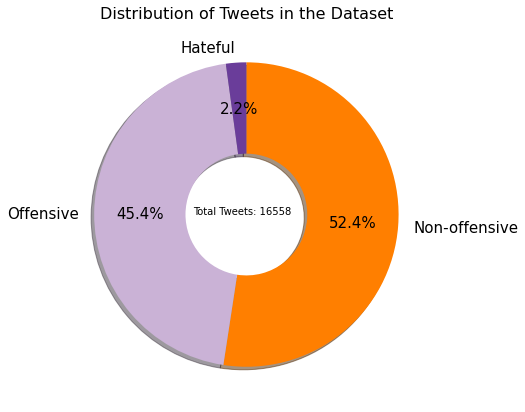

In [25]:
plt.figure(figsize = (7,7))
sorted_counts = df['label'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(df.shape[0]))
plt.title('Distribution of Tweets in the Dataset', fontsize = 16);

In [26]:
df['label'] = df.label.map({0: 'Hateful', 1: 'Offensive', 2: 'Non-offensive'})

##**Implementing a training and predicting Pipeline**

###**Separate training and testing data:**

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df['full_text'], 
                                                    df['label'], 
                                                    random_state=42)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 16558
Number of rows in the training set: 12418
Number of rows in the test set: 4140


####**Vectorize the data:**

In [28]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer(stop_words = 'english', lowercase = True)

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train.values.astype('U'))

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = count_vector.transform(X_test.values.astype('U'))

####**Implement Pipeline:**

In [29]:
def pipeline(learner_list, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []
    
    for learner in learner_list:
        
        # Store the learner name:
        results['Algorithm'] = learner.__class__.__name__

        # Fit the learner:
        start = time() # Get start time
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(X_train, y_train)
        end = time() # Get end time

        # Store the training time
        results['Training Time'] = end - start

        start = time() # Get start time
        predictions_test = learner.predict(X_test)
        predictions_train = learner.predict(X_train)
        end = time() # Get end time

        # Store the prediction time
        results['Prediction Time'] = end - start

        # Compute the Accuracy on Test Set
        results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

        # Compute the Accuracy on Training Set
        results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

        # Compute the F1 Score on Test Set
        results['F1 Score: Test'] = f1_score(y_test, predictions_test)

        # Compute the F1 Score on Training Set
        results['F1 Score: Train'] = f1_score(y_train, predictions_train)

        # Compute the Precision on Test Set
        results['Precision: Test'] = precision_score(y_test, predictions_test)

        # Compute the Precision on Training Set
        results['Precision: Train'] = precision_score(y_train, predictions_train)

        # Compute the Recall on Test Set
        results['Recall: Test'] = recall_score(y_test, predictions_test)

        # Compute the Recall on Training Set
        results['Recall: Train'] = recall_score(y_train, predictions_train)

        # Success
        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')
        
        final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results

####**Put Algorithms in Pipeline:**

In [30]:
# make a list of models
models = [MultinomialNB(), DecisionTreeClassifier(), LinearSVC(), AdaBoostClassifier(), 
          RandomForestClassifier(), BaggingClassifier(),
         SGDClassifier(), KNeighborsClassifier()]

In [42]:
re = pipeline(models, training_data, y_train, testing_data, y_test)
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

Training MultinomialNB


ValueError: ignored

In [34]:
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

NameError: ignored

##**Analyze the results of the Pipeline**


In [37]:

results.reset_index(drop = True)

NameError: ignored

In [38]:
results.describe().loc[['min', 'max'], :]

NameError: ignored

In [39]:
# store the best metric scores
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

NameError: ignored

In [40]:
sns.set_style('darkgrid')
plt.figure(figsize = (17, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']
bars3 = results['Precision: Test']
bars4 = results['Recall: Test']

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

 
# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')

 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0]),
                   'Best Precision: {:.3f} - {}'.format(best_precision['Precision: Test'].values[0], best_precision['Algorithm'].values[0]), 
                    'Best Recall: {:.3f} - {}'.format(best_recall['Recall: Test'].values[0], best_recall['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9.2, 1, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

NameError: ignored

<Figure size 1224x504 with 0 Axes>

In [ ]:

# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

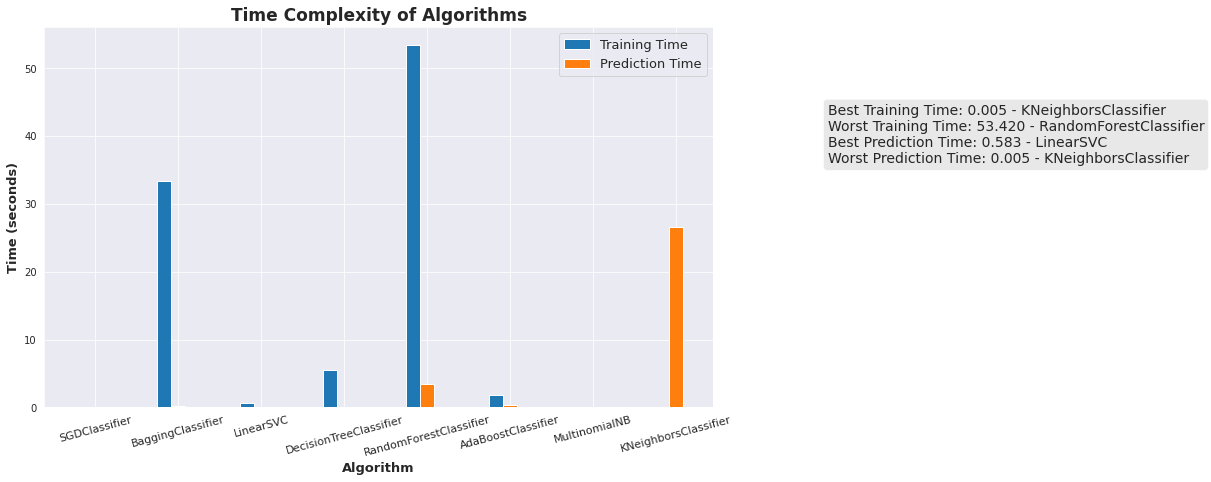

In [ ]:
plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9, 36, textstr, fontsize=14,  bbox=props)

plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17);

##**Tuning Hyperparameters**

In [ ]:
def param_tuning(clf, param_dict, X_train, y_train, X_test, y_test):
    
    # make scorer object
    scorer = make_scorer(f1_score)

    # perform Grid Search for Parameters
    grid_obj = GridSearchCV(estimator = clf,
                           param_grid = param_dict,
                           scoring = scorer,
                           cv = 5)

    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)
    
    # Report the before-and-afterscores
    print(clf.__class__.__name__)
    print("\nOptimized Model\n------")
    print("Best Parameters: {}".format(grid_fit.best_params_))
    print("Accuracy: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("F1-score: {:.4f}".format(f1_score(y_test, best_predictions)))
    print("Precision: {:.4f}".format(precision_score(y_test, best_predictions)))
    print("Recall: {:.4f}".format(recall_score(y_test, best_predictions)))

####**Stochastic Gradient Classifier:**

In [ ]:
# Dict for parameters
param_grid = {
    'alpha' : [0.095, 0.0002, 0.0003],
    'max_iter' : [2500, 3000, 4000]
}

clf_sgd = SGDClassifier()

param_tuning(clf_sgd, param_grid, training_data, y_train, testing_data, y_test)

SGDClassifier

Optimized Model
------
Best Parameters: {'alpha': 0.0002, 'max_iter': 4000}
Accuracy: 0.9289
F1-score: 0.9452
Precision: 0.9692
Recall: 0.9223


####**Decision Tree Classifier:**

In [ ]:
param_grid = {
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 5, 8]
}

clf_dt = DecisionTreeClassifier()

param_tuning(clf_dt, param_grid, training_data, y_train, testing_data, y_test)

DecisionTreeClassifier

Optimized Model
------
Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 5}
Accuracy: 0.9209
F1-score: 0.9399
Precision: 0.9490
Recall: 0.9310


####**Random Forest Classifier:**

In [ ]:

param_grid = {
    'n_estimators': [50,150],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5]
}

clf_rf = RandomForestClassifier()

param_tuning(clf_rf, param_grid, training_data, y_train, testing_data, y_test)

RandomForestClassifier

Optimized Model
------
Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Accuracy: 0.9132
F1-score: 0.9344
Precision: 0.9390
Recall: 0.9298


####**Linear SVC:**

In [ ]:

param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_linsvc = LinearSVC()

param_tuning(clf_linsvc, param_grid, training_data, y_train, testing_data, y_test)

LinearSVC

Optimized Model
------
Best Parameters: {'C': 0.25}
Accuracy: 0.9253
F1-score: 0.9429
Precision: 0.9597
Recall: 0.9266


##**Conclusion:**


***We found Stochastic Gradient to be the best suited model for our data. We achieved the following performance parameters:***

***Accuracy: 92.81 %***

***Precision: 96.97 %***

***Recall: 91.94 %***

***F1-Score: 94.39 %***


##**Save the model:**

In [ ]:
filename = 'cb_sgd_final.sav'
joblib.dump(clf_sgd, filename)

['cb_sgd_final.sav']